In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
from shapely.geometry import Point, Polygon
import os
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab_Notebooks/ECSE415_Final_Project/' # Kun's path, comment out when needed
# path = '' # Jay's path
# path = '' # Kamy's path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Positive patches of this image:
[2]


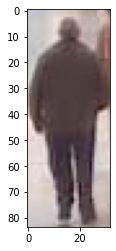

[7]


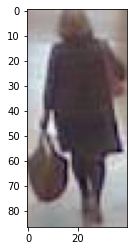

[6]


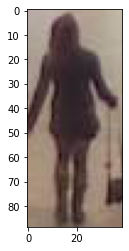

[9]


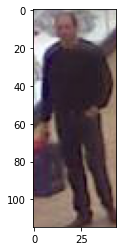

[10]


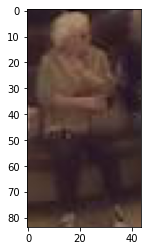

[4]


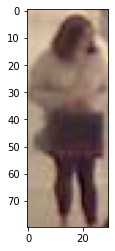

[20]


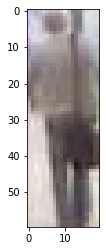

[13]


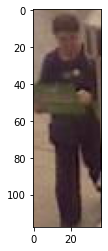

[14]


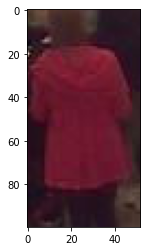

[3]


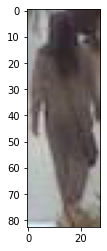

[18]


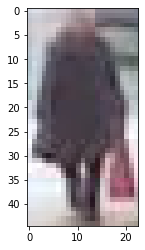

[5]


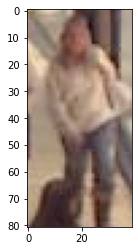

[19]


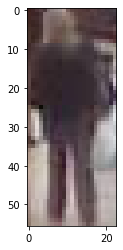

[22]
[12]


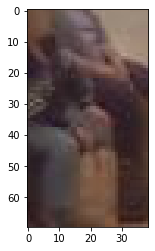

[8]


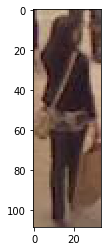

[17]


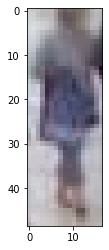

[16]


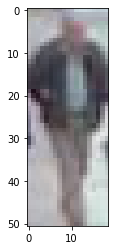

[11]


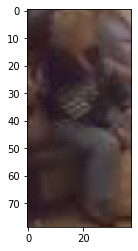

[1]


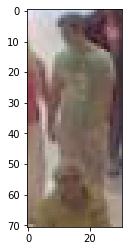

[21]


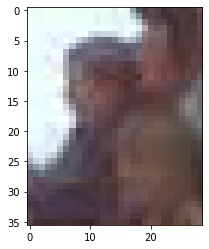

[0]


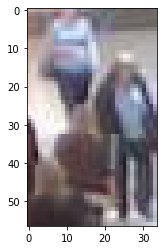

[15]


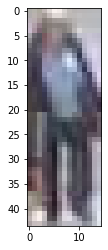

Negative patches of this image


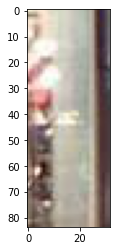

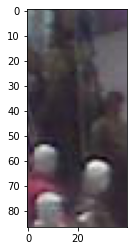

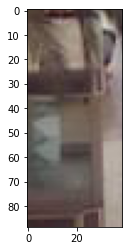

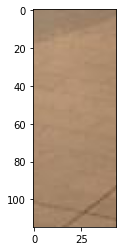

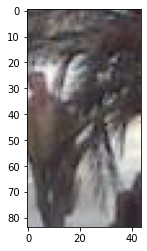

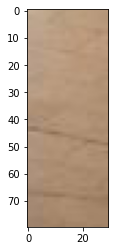

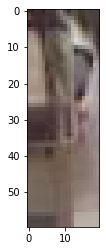

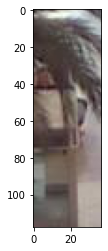

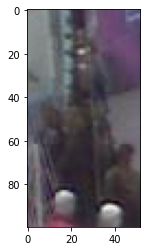

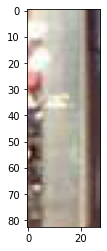

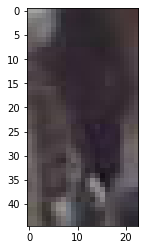

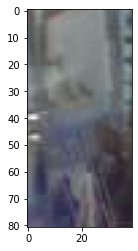

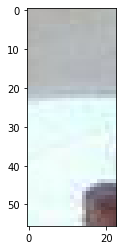

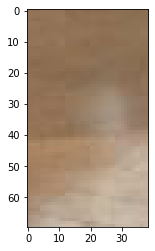

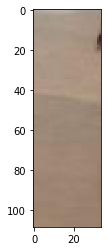

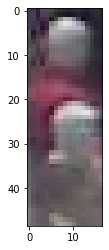

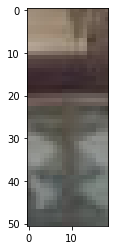

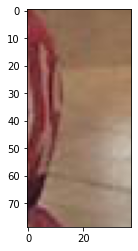

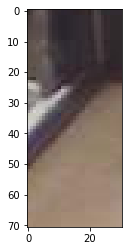

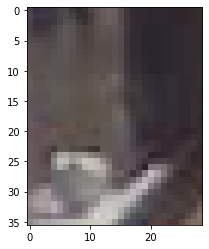

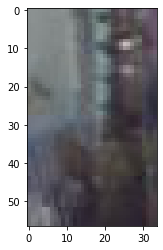

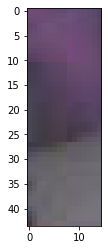

Tihs image:


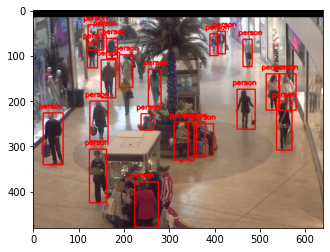

Detected people in 1 frames which are stored in the detected_images array
Extracted 22 positive patches which are stored in the positive_patches array
Extracted 22 negative patches which are stored in the negative_patches array


In [48]:
# Inspired from https://medium.com/@luanaebio/detecting-people-with-yolo-and-opencv-5c1f9bc6a810

images = []
path_frames = path + 'frames/'
detected_frames = []
positive_patches = []
negative_patches = []


# load images from frames/
for count,image_path in enumerate(os.listdir(path_frames)):
  if count > 0:
    break
  input_path = os.path.join(path_frames, image_path)
  image = plt.imread(input_path)
  images.append(image)

Width = image.shape[1]
Height = image.shape[0]

# load class names
classes = None
with open(path + 'coco.names', 'r') as f:
  classes = [line.strip() for line in f.readlines()]

# read pre-trained model and config file
net = cv2.dnn.readNet(path + 'yolov3.weights', path + 'cfg/yolov3.cfg')

for image in images:
  image_patches = image.copy()

  # create input blob 
  # set input blob for the network
  # blob = cv2.dnn.blobFromImage(image, scalefactor=?, size=?, mean substraction value=?, swapRB=?)
  blob = cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False)
  net.setInput(blob)

  # run inference through the network
  layer_names = net.getLayerNames()
  output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

  # gather predictions from output layers
  outs = net.forward(output_layers)

  # initiatialization
  class_ids = []
  confidences = []
  boxes = []
  conf_threshold = 0.5
  nms_threshold = 0.4
  boxes_positive_patches = []

  # for each detetion from each output layer get the confidence, class id, bounding box params and ignore weak detections (confidence < 0.5) 
  for out in outs:
    for detection in out:
      scores = detection[5:] # from 0-4, is matched box coordinates/dimension info, from 5 onwards is an array of confidence scores towards each different class in classes
      class_id = np.argmax(scores) # return the index of max confidence
      confidence = scores[class_id] # get the confidence score
      if confidence > conf_threshold:
        center_x = int(detection[0] * Width)
        center_y = int(detection[1] * Height)
        w = int(detection[2] * Width)
        h = int(detection[3] * Height)
        x = center_x - w / 2
        y = center_y - h / 2

        #####################################
        #                                   #
        #  moved "extract positive patches" #
        #  part from here to post NMS to    #
        #  further remove duplicated ones   #
        #                                   #
        #####################################

        # store captured class_id number
        class_ids.append(class_id)
        # store the confidence towards the above class_id
        confidences.append(float(confidence))
        # store the captured boxes
        boxes.append([x, y, w, h])
        # Would need to generate negative patch here and append it to negative_patches array

  # apply non-max suppression: extract the highest confidence box index among all partially overlapped boxes
  indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold )

  print("Positive patches of this image:")

  #check if is people detection, if so, draw boxes in the original image, and extract positive patches
  for i in indices:
    print(i)
    i = i[0] # i was a 1x1 array, make it a scaler for indexing into boxes
    box = boxes[i]
    if class_ids[i]==0:
      label = str(classes[class_id])

      ################ extract positive patches starts ##############

      x = box[0]
      y = box[1]
      w = box[2]
      h = box[3]
      positive_patch = np.squeeze(image_patches)
      positive_patch = positive_patch[int(y):int(y+h),int(x):int(x+w)]
      positive_patches.append(positive_patch)

      # extract positive patch box in an array 
      boxes_positive_patches.append(box)

      # show positive patches
      plt.imshow(positive_patch)
      plt.show()

      ############### extract positive patches end #################
      
      # draw selected boxes in the original image
      cv2.rectangle(image, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (255, 0, 0), 2)
      cv2.putText(image, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

  ############## extract negative patches start ###############

  print("Negative patches of this image")

  # foreach positie patch, create a negative patch at a random location that does not intersect with any of the positive patches
  for boxA in boxes_positive_patches:

    # extract positive patch dimension
    wA = boxA[2]
    hA = boxA[3]

    max_xA1 = Width - wA
    max_yA1 = Height - hA

    # initialize the random image status to dirty until loop through all positive patches to confirm no intersactions
    n_patch_status = 'dirty'

    # generate negative patch candidates if patch status is 'dirty'
    while n_patch_status == 'dirty':
      # generate a negative patch candidate with the same dimension as the positive patch but located randomly elsewhere in the image
      xA1 = np.random.randint(0,max_xA1)
      yA1 = np.random.randint(0,max_yA1)
      xA2 = xA1 + wA
      yA2 = yA1 + hA
      polyA = ([(xA1,yA1),(xA1,yA2),(xA2,yA1),(xA2,yA2)])
      # p1 = Point(xA1,yA1)
      # p2 = Point(xA1,yA2)
      # p3 = Point(xA2,yA1)
      # p4 = Point(xA2,yA2)
      # print (f'w range: {wA}, h range: {hA}, xA1 = {xA1}, yA1 = {yA1}')
      # check the negative patch candidate against each of the positive patches
      for boxB in boxes_positive_patches:
        xB1 = boxB[0]
        yB1 = boxB[1]
        wB = boxB[2]
        hB = boxB[3]
        xB2 = xB1 + wB
        yB2 = yB1 + hB
        polyB = Polygon([(xB1,yB1),(xB1,yB2),(xB2,yB1),(xB2,yB2)])
        #if ((xB1<=xA1<=xB2 and yB1<=yA1<=yB2) or (xB1<=xA1<=xB2 and yB1<=yA1<=yB2) or (xB1<=xA1<=xB2 and yB1<=yA1<=yB2))
        # if any corner of the negative patch candidate falls within the positive patch, disregard and generate a new one
        #if p1.within(polyB) == 'True' or p2.within(polyB) == 'True' or p3.within(polyB) == 'True' or p4.within(polyB) == 'True':
        if Polygon(polyA).intersects(Polygon(polyB)):
          n_patch_status = 'dirty'
          break
        # else temporarily set the negative patch candidate as clean
        else:
          n_patch_status = 'clean'
      # after a particular negative patch candidate has been confirmed not intersecting with any of the positive patches, extract it.
      if n_patch_status == 'clean':
        negative_patch = np.squeeze(image_patches)
        negative_patch = negative_patch[int(yA1):int(yA2),int(xA1):int(xA2)]
        negative_patches.append(negative_patch)

        # show negative patches
        plt.imshow(negative_patch)
        plt.show()

  ############## extract negative patches end ###############

  # show image
  print("Tihs image:")
  detected_frames.append(image)
  plt.imshow(image)
  plt.show()

print('Detected people in ' + str(len(detected_frames)) + ' frames which are stored in the detected_images array')
print('Extracted ' + str(len(positive_patches)) + ' positive patches which are stored in the positive_patches array')
print('Extracted ' + str(len(negative_patches)) + ' negative patches which are stored in the negative_patches array')

## Todo:
- Collecting negative patches
- Computing HoG features
- Feeding pos/neg patches to SVM
- Implement SVM
- Duplicate elimination
- Test it